# Assignment 3


*Please fill out the relevant cells below according to the instructions. When done, save the notebook and export it to PDF, upload both the `ipynb` and the PDF file to Canvas.*

## Group Members

*Group submission is highly encouraged. If you submit as part of group, list all group members here. Groups can comprise up to 5 students.*
* Fan Chen
* Clarissa Ding
---

## Problem 1: Hubble goes GP

You will remember that Edwin Hubble produced the first observational evidence for the expansion of the universe by linear regression of velocities and distances of nearby galaxies. One main limitation with his analysis is the lack of error estimates for any of the observed quantities. In Assignment 1, we assumed that all observed distances have and unknown but *the same* error. Here we will use the flexibility of Gaussian Processes instead.

### Problem 1.1 (3pts):

Load the data file `hubble_corrected.txt`. It's a version of the data from Assignment 1, Problem 4, that applies several astronomically motivated corrections, but still comes without error estimates.

Perform GP regression of the relation $R(V)$ for noisy data with unknown variance from `scikit-learn` that we discussed during the lecture. Use `ConstantKernel * Matern` (a robust replacement of `RBF`) and `WhiteKernel` kernel functions. Plot the data, the regression mean and $\pm1\sigma$ confidence regions. Don't forget axis labels.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel as C
np.random.seed(42)

(24, 1) (24,)


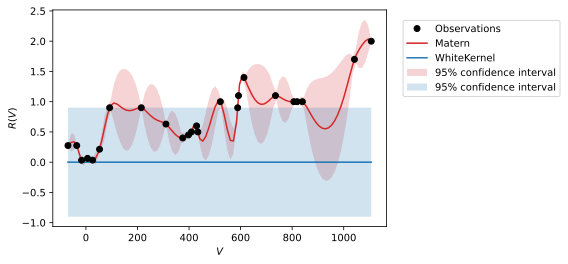

In [2]:
data = np.genfromtxt('hubble_corrected.txt', names=True, dtype=None)
X, y = data['V'], data['R']
X = X.reshape(-1, 1)
y = y.ravel()
print(X.shape, y.shape)
x = np.linspace(X.min(), X.max(), 100).reshape(-1,1)

kernel1 = C(1.0, (1e-3, 1e3)) * Matern(1, length_scale_bounds=(1e-2, 1e2))
kernel2 = WhiteKernel(noise_level=0.1)
kernels = [kernel1, kernel2]
colors = ['C3', 'C0']
labels = ['Matern', 'WhiteKernel']
plt.figure()
plt.plot(X, y, 'ko', zorder=10, label='Observations')
for kernel, color, label in zip(kernels, colors, labels):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(X, y)
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y_pred, color=color, label=label)
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.00 * sigma,
                            (y_pred + 1.00 * sigma)[::-1]]),
             alpha=.2, fc=color, ec='None', label='95% confidence interval')
plt.xlabel('$V$');
plt.ylabel('$R(V)$');
plt.legend(loc=(1.05, 0.6));

### Problem 1.2 (1pt):

The approach in 1.1 suffices to support Hubble's original finding that the universe is in fact expanding, but it is not satisfying for two reasons:

1. The GP mean function is not a straight line, in contrast to our (well: Hubble's) theoretical prejudice.
2. The variance of the data is assumed to be constant and uncorrelated: $\Sigma_{y,i}=\Sigma_y\ \forall i$.

Let's say that we are certain that the data model is linear without intercept. Then we can remedy both of these problems by specifying the analytic likelihood as a stochastic process with two sets of RVs:

$$
\begin{align}
y(x) &= b x + e(x)\\
e(x)&\sim\mathrm{GP}(\mu(x), \kappa(x,x'))
\end{align}
$$

That means we impose that data come from a linear model (with only a slope parameter and no intercept) and that the *residual errors* $e$ of the linear model come from a GP. That evidently addresses shortcoming 1, and it allows for a more flexible error model.

To visualize the approach, let's break it up into two steps.

1. Compute $e_i = R_i - \tilde{b}_{MLE} V_i$, where $\tilde{b}_{MLE}$ is the MLE of the ordinary linear regression. 
2. Perform GP regression of $e(V)$ with the same functional form of the kernel as in 1.1.

$y = bx, b = y x^{-1}$

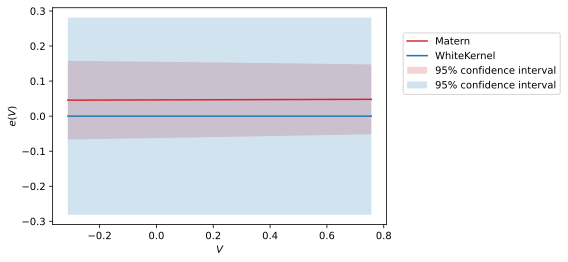

In [3]:
X, y = data['V'], data['R']
X = X.reshape(-1, 1)
b_mle = np.linalg.inv(X.T @ X) @ X.T @ data['R']
e = data['R'] - b_mle * data['V'] 
test = np.linspace(e.min(), e.max(), 50).reshape(-1,1)

for kernel, color, label in zip(kernels, colors, labels):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(X, e)
    e_pred, sigma = gp.predict(test, return_std=True)
    plt.plot(test, e_pred, color=color, label=label)
    plt.fill(np.concatenate([test, test[::-1]]),
             np.concatenate([e_pred - 1.00 * sigma,
                            (e_pred + 1.00 * sigma)[::-1]]),
             alpha=.2, fc=color, ec='None', label='95% confidence interval')
plt.xlabel('$V$');
plt.ylabel('$e(V)$');
plt.legend(loc=(1.05, 0.6));

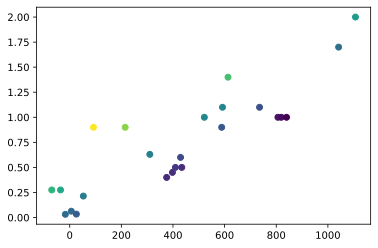

In [4]:
plt.scatter(X, y, c = e)

### Problem 1.3 (3pts): 

The linear regression errors $e$ from 1.2 appear locally clustered: they form groups in $(V,R)$. These correlations of the errors can be accounted for by the GP, but so far the linear regression does not "know" of this new modeling flexibility. Let's find a way to optimize the linear model *and* the GP simultaneously.

The likelihood for the data $\lbrace(x_1,y_1),\dots,(x_N,y_N)\rbrace$ is

$$
\begin{align}
\ln p(\lbrace y_i\rbrace\mid\lbrace x_i \rbrace, b, \theta) &= -\frac{1}{2} e^\top K_\theta^{-1} e - \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)\\
&= -(y - b x)^\top K_\theta^{-1} (y - b x)- \frac{1}{2}\ln|K_\theta | - \frac{N}{2}\ln(2\pi)
\end{align}
$$

where $K_\theta=\kappa(x,x';\theta)$ is the error covariance matrix, and $\theta$ denotes the parameter vector of the kernel function. In other words, $K$ is the covariance matrix of the $e_i$, whose parameters we seek to determine while also determining $b$ through minimizing the $e_i$.

For this to be meaningful we need to specify $\kappa$. The deviations from the mean appear locally clustered, which suggest a distance-based kernel. Like above, we'll use the robust Matérn 3/2 kernel:

$$
\kappa(x,x'; \alpha, \tau) = \alpha^2 \left(1+\frac{\sqrt{3} d}{\tau}\right)\exp\left(-\frac{\sqrt{3} d}{\tau}\right)
$$

where $d=\lVert x-x'\rVert_2$. To account for some (unknown) constant noise level, the data covariance matrix $K$ contains a diagonal term $\sigma_y^2\mathbf{I}$ with the unknown noise variance $\sigma_y^2$ (that's what the `WhiteKernel` above does):

$$
K_\theta \rightarrow K_Y \equiv \sigma_y^2\mathbf{I} + \kappa(x,x^\top; \alpha, \tau)  
$$

\??? $\kappa(x,x^\prime; \alpha, \tau) $ 
typo?

Implement the kernel function and the log likelihood above. Instead of a grid search, compute the gradients wrt the parameters $b$, $\sigma_y$, $\alpha$, and $\tau$ with `jax.grad`. Evaluate the gradients at $(b=0.0015, \sigma_y=0.1, \alpha=1, \tau=100)$. 

**Hints:**  

* `import jax.numpy as jnp`
* If you cannot install `jax`, try [`autograd`](https://github.com/HIPS/autograd) (its predecessor, installable with `pip install autograd`). Its `grad` function works just the same, but there's no built-in just-in-time compilation.

In [47]:
# a = np.array([1, 2, 3])
# a = a.reshape(-1, 1)
# print(a, a.T)
# da = a-a.T
# print(da)
# print(da * np.exp(pow(da,2)))

In [16]:
dx = X - X.T
dx.shape

(24,)

In [8]:
def minusloglikelihood(data, para):
    b, sigma, a, tau = para
    X, y = data['V'], data['R']
    X = X.reshape(-1, 1)
    b_mle = np.linalg.inv(X.T @ X) @ X.T @ data['R']
    e = data['R'] - b_mle * data['V'] 
    
    sqr3 = 1.7320508075688772
    d = np.sqrt(pow(X - X.T, 2))
    cov = sigma**2 * np.eye(len(data)) + pow(a, 2) * (1 + sqr3 * d/tau) * np.exp(-sqr3 * d/tau)
    return 1/2 * (e.T @ (np.linalg.inv(cov) @ e)) + 1/2 * np.log(np.linalg.det(cov)) #- len(data)/2 * np.log(2 * np.pi)

b, sigma, a, tau = 0.0015, 0.1, 1, 100
parameters = (b, sigma, a, tau)
minusloglikelihood(data, parameters)

-15.851426674869215

In [11]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
# key = random.PRNGKey(0)

def loss(b, sigma, a, tau):
    sqr3 = 1.7320508075688772
    X = jnp.reshape(datV, (-1, 1))
    y = jnp.reshape(datR, (-1, 1))
    e = y - b * X
    d = jnp.sqrt(jnp.power(X - X.T, 2))
    cov = jnp.power(sigma, 2) * jnp.eye(X.size) + jnp.power(a, 2) * (1 + sqr3 * d/tau) * jnp.exp(-sqr3 * d/tau)
    return jnp.sum(1/2 * (e.T @ (jnp.linalg.inv(cov) @ e)) + 1/2 * jnp.log(jnp.linalg.det(cov))) #- len(data)/2 * np.log(2 * np.pi)


datR = jnp.array(data['R'])
datV = jnp.array(data['V'])
b, sigma, a, tau = 0.0015, 0.1, 1., 100.
parameters = (b, sigma, a, tau)
print("negative log likelihood (without the constant term): ", loss(b, sigma, a, tau))
print("First derivative: ")
g = grad(loss,(0, 1, 2, 3))(*parameters)
print("wrt b: ", g[0])
print("wrt sigma: ", g[1])
print("wrt a: ", g[2])
print("wrt tau: ", g[3])
# v, g = value_and_grad(loss, (0, 1, 2, 3))(*parameters)

negative log likelihood (without the constant term):  -15.831581
First derivative: 
wrt b:  -395.28906
wrt sigma:  28.358133
wrt a:  14.765724
wrt tau:  -0.0891439


### Problem 1.4 (2pt):
    
Use the gradient function from 1.3 to perform first-order gradient descent. Choose suitable step sizes and parameter initializations. Plot the loss curve (negative log likelihood as a function of iteration counter) and terminate when it appears to have converged. 

**Hint**: Make sure that all parameters stay positive during every iteration.

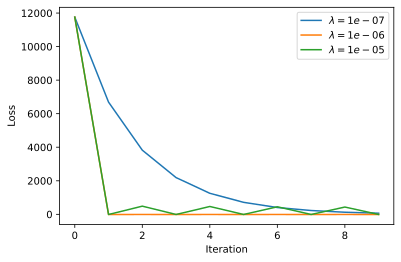

In [8]:
from jax import jit, value_and_grad
def loss(b, sigma, a, tau):
    sqr3 = 1.7320508075688772
    X = jnp.reshape(datV, (-1, 1))
    y = jnp.reshape(datR, (-1, 1))
    e = y - b * X
    d = jnp.sqrt(jnp.power(X - X.T, 2))
    cov = jnp.power(sigma, 2) * jnp.eye(X.size) + jnp.power(a, 2) * (1 + sqr3 * d/tau) * jnp.exp(-sqr3 * d/tau)
    return jnp.sum(1/2 * (e.T @ (jnp.linalg.inv(cov) @ e)) + 1/2 * jnp.log(jnp.linalg.det(cov))) #- len(data)/2 * np.log(2 * np.pi)

def loss2(params): # simply unpack parameters
    b, sigma, a, tau = params
    return loss(b, sigma, a, tau)

# @jit
def optimize(params, step_size, steps=10):
    losses = []
    for step in range(steps):
        # compute value and gradients of the loss function
        value, grads = value_and_grad(loss2)(params)
        losses.append(value)
        # update parameters with first order downhill step
        params = tuple(x - step_size * dx if x - step_size * dx > 0 else 1e-23 for x, dx in zip(params, grads))
    return params, losses

plt.figure()
b, sigma, a, tau = 0.1, 0.1, 1., 100.
para = (b, sigma, a, tau)
params = para
for step_size in [0.0000001, 0.000001, 0.00001]:
    params = para
    _, losses = optimize(params, step_size)
    plt.plot(losses, label='$\lambda={}$'.format(step_size))
plt.legend();
plt.xlabel('Iteration');
plt.ylabel('Loss');

### Problem 1.5 (1pt):

Visualize the result:

1. Plot the matrix $K_\theta$ for the data with the parameters $\tilde\theta$ you have determined in 1.4.
2. Plot the data, the prediction mean and the $\pm1\sigma$ confidence regions. For that, compute $e = y - \tilde{b} x$, compute the mean $\mu_*$ and covariance $\Sigma_*$ of the GP for $e$. Note that the cross-covariance $K_{X*}$ does not contain a diagonal error term. The final prediction is then $\tilde{y} = \tilde{b} x + \mu_* \pm \mathrm{Diag}\left(\Sigma_*\right)^{1/2}$.

0.1 0.1 1.0 100.0


<Figure size 432x288 with 0 Axes>

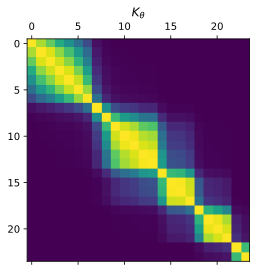

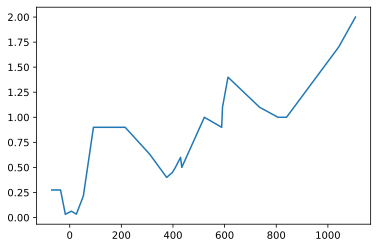

In [20]:
b, sigma, a, tau = params
print(b, sigma, a, tau)
d = np.sqrt(np.power(X - X.T, 2))
cov = np.power(sigma, 2) * np.eye(X.size) + np.power(a, 2) * (1 + np.sqrt(3) * d/tau) * np.exp(-np.sqrt(3) * d/tau)
plt.figure()
plt.matshow(cov)
plt.title(r'$K_\theta$')

plt.figure()
plt.plot(X, y)